# Axolotl neuron regeneration

This tutorial will walk you through the different steps to train a neural network to learn a differentaition potential from spatial transcirptomics through time, using STORIES. As a demo dataset, we will use a subset of axolotl neuron regeneration from the [ARTISTA](https://db.cngb.org/stomics/artista/) dataset by Wei et al.

## Imports

STORIES relies on AnnData for input/output, and on the JAX ecosystem for GPU computations.

In [1]:
import os

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import optax
import scanpy as sc

import stories

Check that JAX detects the GPU. If not, refer to the [JAX installation page](https://jax.readthedocs.io/en/latest/installation.html).

In [2]:
import jax

jax.devices()

[cuda(id=0)]

## Load the data

You can download the processed demo dataset in the .h5ad format from [this Figshare link](https://figshare.com/s/209a3b6408ea8849d5ec). The original data comes from the [ARTISTA](https://db.cngb.org/stomics/artista/) dataset.

In [3]:
#!wget https://figshare.com/ndownloader/files/47845111?private_link=209a3b6408ea8849d5ec

The important fields for this tutorial are the following:
- `adata.obs["time"]`: a number indicating the time point. Time points do not have to be evenly spaced. *Importantly, STORIES assumes one slice per timepoint*.
- `adata.obs["growth"]`: a score computed based on estimated proliferation and apoptosis rates, which estimated the number of descendants of a cell. STORIES can weight cells proportionally to such a score. This is optional, and by default all cells have the same weight.
- `adata.obsm["X_pca_harmony"]`: a batch-corrected PCA embedding of gene expression data. This is the input of the model.
- `adata.obsm["X_isomap"]`: a 2D embedding of the data. Here, we use Isomap, but you could used PHATE or UMAP instead.
- `adata.obsm["spatial"]`: 2D spatial coordinates of the cells.

In [4]:
# Load the data
adata = ad.read_h5ad("../../../data/artista/artista_traj_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 5904 × 10000
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'Annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'apoptosis', 'nsc', 'growth', 'time'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'Annotation_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_isomap', 'X_pca', 'X_pca_harmony', 'X_spatial', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Preprocess the data

In order to make the gene expression and spatial terms more comparable, we suggest some basic rescaling of the data.

In [5]:
# Select a given number of principal components then normalize the embedding.
adata.obsm["X_pca_harmony"] = adata.obsm["X_pca_harmony"][:, :20]
adata.obsm["X_pca_harmony"] /= adata.obsm["X_pca_harmony"].max()

In [6]:
# Center and scale each timepoint in space.
# Importantly, we have only one slice per time point.
timepoints = np.sort(np.unique(adata.obs["time"]))
adata.obsm["spatial"] = adata.obsm["spatial"].astype(float)
for t in timepoints:
    idx = adata.obs["time"] == t

    mu = np.mean(adata.obsm["spatial"][idx, :], axis=0)
    adata.obsm["spatial"][idx, :] -= mu

    std = np.std(adata.obsm["spatial"][idx, :], axis=0)
    adata.obsm["spatial"][idx, :] /= std

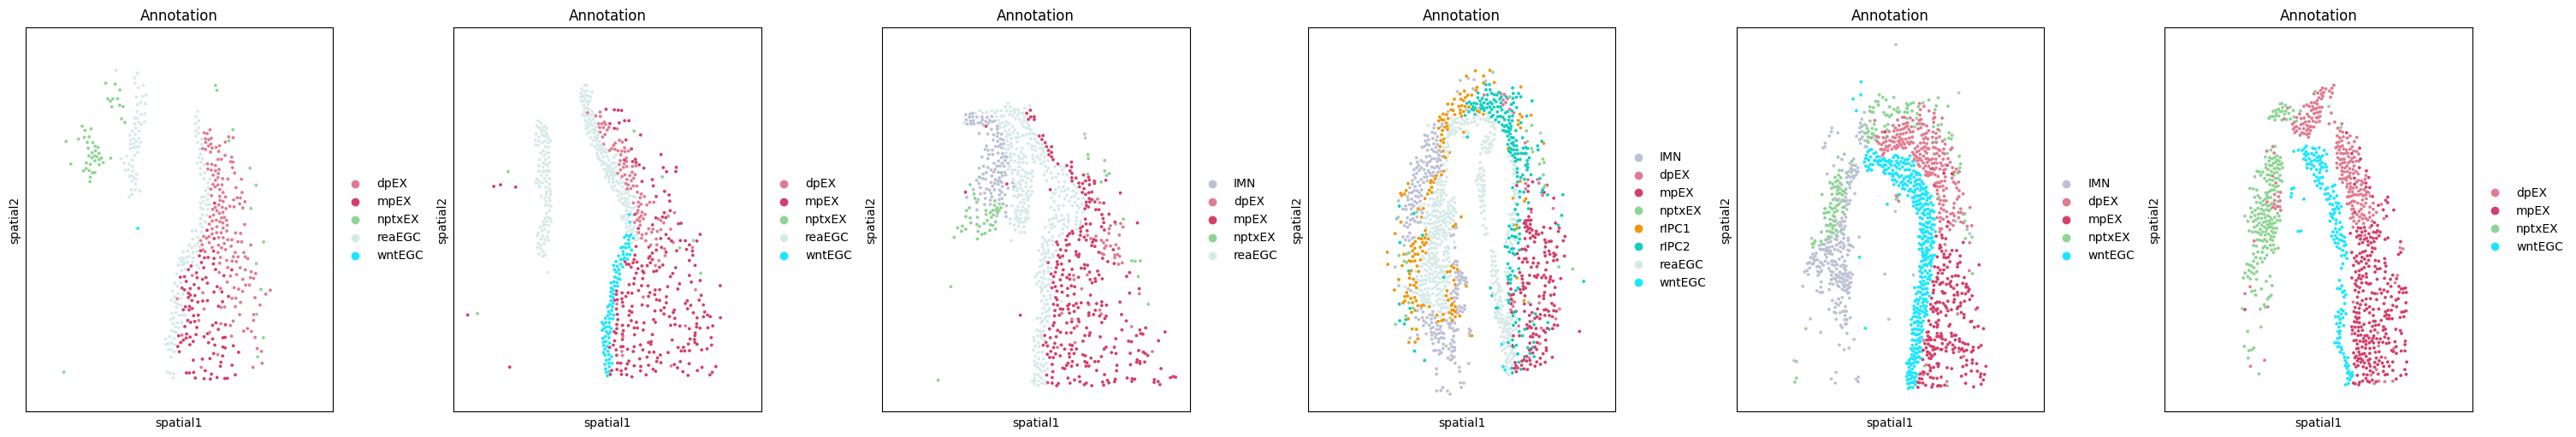

In [7]:
fig, axes = plt.subplots(
    1, 6, figsize=(30, 5), sharey=True, sharex=True, constrained_layout=True
)
for i, t in enumerate(sorted(adata.obs["time"].unique())):
    idx = adata.obs["time"] == t
    sc.pl.embedding(
        adata[idx], "spatial", color="Annotation", s=30, ax=axes[i], show=False
    )

## Train the model

The most important parameter when defining the model is the relative weight of space comapred to gene expression. Here, we set it to `1e-3`. Larger values will give more importance to space, and a value of 0 will ignore space.

In [8]:
# Initialize the model.
model = stories.SpaceTime(quadratic_weight=1e-3)

Now, we can start to train the model. `model.fit()` accepts additional parameters such as the number of iterations, and the batch size. We use AdamW with a cosine decay as an optimizer. The training will stop when the validation loss stops improving, and weights corresponding to the vest validation loss are kept.

In [9]:
scheduler = optax.cosine_decay_schedule(1e-2, 10_000)
model.fit(
    adata=adata,
    time_key="time",
    omics_key="X_pca_harmony",
    space_key="spatial",
    weight_key="growth",
    optimizer=optax.adamw(scheduler),
    checkpoint_manager=f"{os.getcwd()}/ckpt_axolotl",
)

 58%|█████▊    | 5751/10000 [48:10<35:35,  1.99it/s, iteration=5752, train_loss=0.2511269, val_loss=0.34566662]   

Met early stopping criteria, breaking...


## Display the potential

STORIES learned a potential function. Let us apply it to all cells, populating the AnnData object with a new field `adata.obs["potential"]`.

In [10]:
stories.tools.compute_potential(adata, model, "X_pca_harmony")

In [11]:
palette = {
    "IMN": "#FFE368",
    "dpEX": "#FF6666",
    "mpEX": "#d33f6a",
    "nptxEX": "#ef9708",
    "rIPC1": "#2CCD39",
    "rIPC2": "#7E0AD1",
    "reaEGC": "#00F2CE",
    "wntEGC": "#1ce6ff",
}

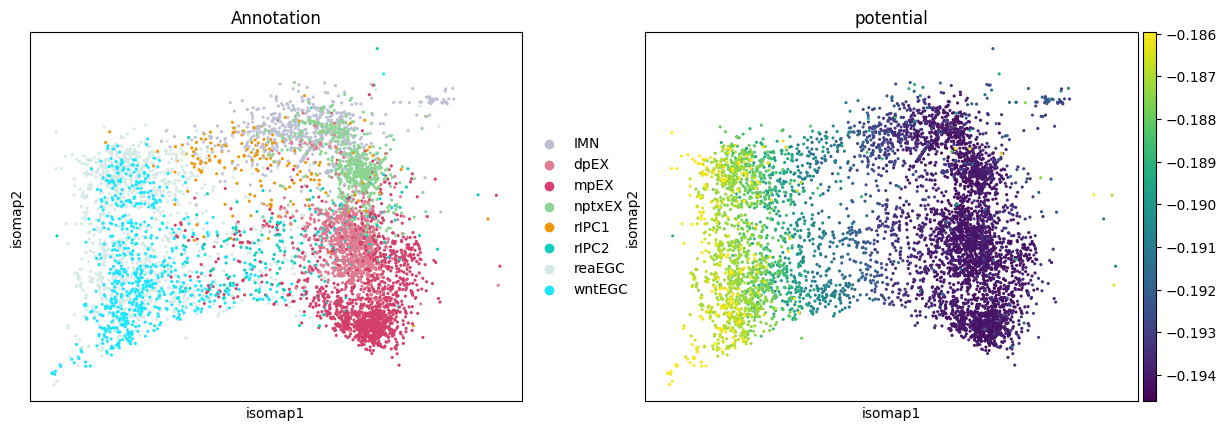

In [12]:
sc.pl.embedding(
    adata,
    basis="isomap",
    color=["Annotation", "potential"],
    vmax="p98",  # Colorbar up to the 98th percentile
)

## Display the velocity

The opposite of the potential's gradient points towards more differentiated states. Let us compute this velocity for all cells, populating the AnnData object with a new field `adata.obsm["X_velo"]`.

In [13]:
stories.tools.compute_velocity(adata, model, "X_pca_harmony")

STORIES provides a convenient wrapper function around CellRank to visualize this velocity. Trajectories from EGCs to mature neurons clearly emerges.

100%|██████████| 5904/5904 [00:01<00:00, 3474.23cell/s]


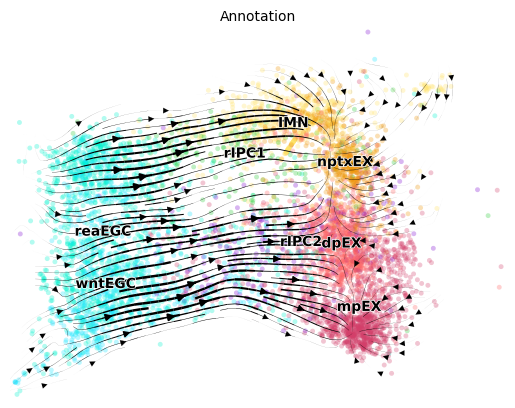

In [14]:
stories.tools.plot_velocity(
    adata, "X_pca_harmony", basis="isomap", color="Annotation", palette=palette, s=50,
)

## Gene trends

Let us explore the reaEGC-rIPC1-IMN-nptxEX trajectory in more detail. We can subset the AnnData to the cell types of interest.

In [15]:
adata = adata[adata.obs["Annotation"].isin(["reaEGC", "rIPC1", "IMN", "nptxEX"])].copy()

Gene trends are usually computed on smoothed count data. Here, we used MAGIC on the harmonized PCA space to account for batch correction.

In [16]:
# pip install magic-impute
import magic

magic_operator = magic.MAGIC()
magic_operator.fit(adata.obsm["X_pca_harmony"])
diff_op_t = np.linalg.matrix_power(magic_operator.diff_op.A, 3)
adata.X = diff_op_t @ np.log1p(adata.layers["counts"].A)

Running MAGIC on 2715 cells and 20 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.14 seconds.
  Calculating affinities...
  Calculated affinities in 0.16 seconds.
Calculated graph and diffusion operator in 0.31 seconds.


For each gene, let us regress the smoothed gene expression from the potential. By default, this is done with a spline regression but you can specify your own model. This populates the AnnData object with a new layer, `adata.layers["regression"]`, and gene-wise information: `adata.var["regression_score"]` (how good the fit is), and `adata.var["regression_argmax"]` (for which potential the highest regressed expression is achieved).

In [17]:
stories.tools.regress_genes(adata)

10000it [01:31, 108.72it/s]


We can represent this information conveniently using the following function. Since cells are ranks with increasing potential, the differentiation process goes from right to left.

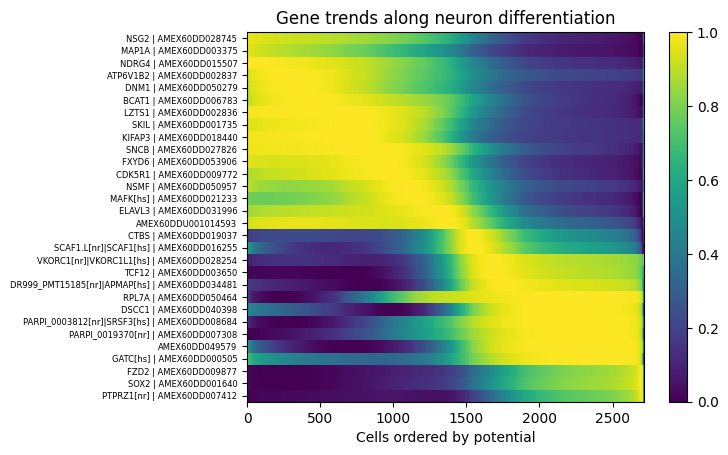

In [18]:
sorted_genes_names = stories.tools.select_driver_genes(adata, n_stages=10, n_genes=3)
fig, axes = stories.tools.plot_gene_trends(
    adata, sorted_genes_names, title="Gene trends along neuron differentiation"
)

The plot above shows regressed gene expression. The function `plot_single_gene_trend` enables to plot the original gene expression along the potential.

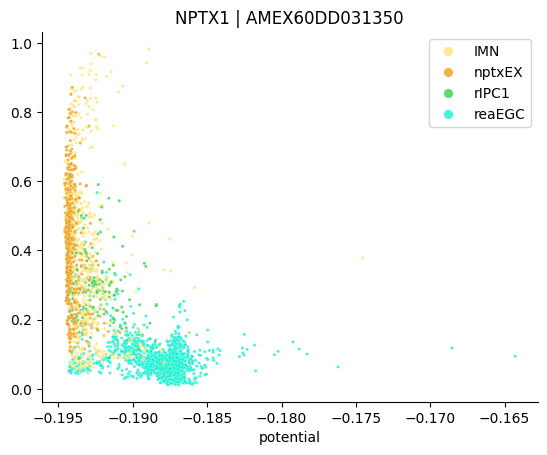

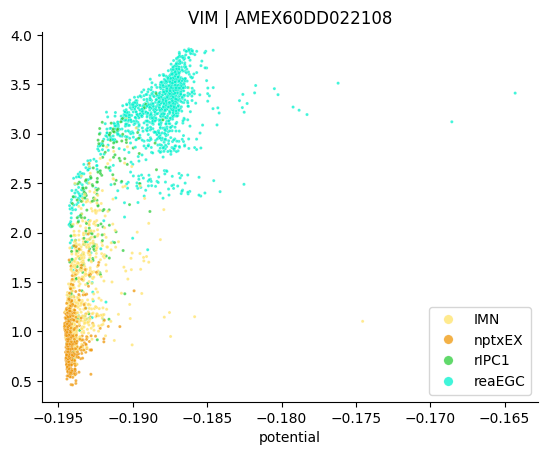

In [19]:
stories.tools.plot_single_gene_trend(adata, "NPTX1 | AMEX60DD031350", s=5, palette=palette, alpha=0.75, annotation_key="Annotation")
stories.tools.plot_single_gene_trend(adata, "VIM | AMEX60DD022108", s=5, palette=palette, alpha=0.75, annotation_key="Annotation")

## Transcription factors

Finally, STORIES provides a function to perform a Wilcoxon rank-sum test for TF enrichment among the best-scoring genes. It expects a TSV file from the TRRUST database, which has a file for mouse and a file for human TF-target interactions.

In [20]:
#!wget https://www.grnpedia.org/trrust/data/trrust_rawdata.human.tsv

Since there is no file for axolotl, the following piece of code extracts human gene names from the original annotation.

In [46]:
import re
def extract_gene_name(text):
    # Regular expression patterns ordered by priority
    patterns = [
        r"(\b\w+)\s*\|",  # gene name without hint (highest priority)
        r"(\b\w+)\[hs\]",  # [hs] hint
        r"(\b\w+)\[nr\]",  # [nr] hint
        r"(\b\w+)\[.*?\]",  # any other hint
        r"(AMEX[\da-zA-Z]+)",  # AMEX code
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return match.group(1)

    return text  # default return if no pattern matches


adata.var["clean_name"] = [extract_gene_name(g) for g in adata.var_names]

100%|██████████| 591/591 [00:01<00:00, 339.47it/s]


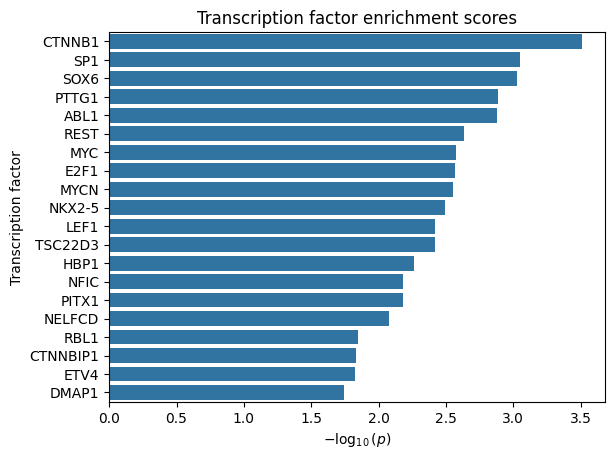

In [72]:
stories.tools.tf_enrich(adata, trrust_path="trrust_rawdata.human.tsv", gene_key="clean_name")